In [1]:
import sys
import os
sys.path.append('../../classification')
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import sklearn.metrics as metrics
import model_evaluator
import data_import
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import roc_curve
import plotly.express as px
import plotly.graph_objects as go
from plotly import tools
from sklearn.preprocessing import StandardScaler

In [2]:
X_tot, df_tot, X_train, X_test, y_train, y_test = data_import.import_data_train_test('Contagio')

/Users/mattiarosso/Desktop/Eurecom/Fall_Semester/MALIS/Project/malicious_pdf_detection/models/svm


## Parallel coordinates plot

/Users/mattiarosso/opt/anaconda3/envs/malis/lib/python3.8/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



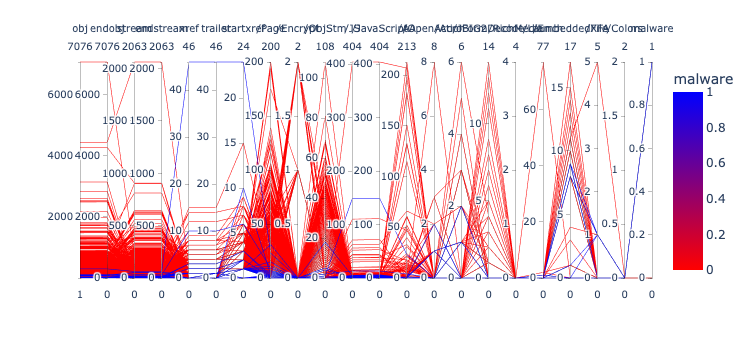

In [3]:
df_tot_parallel = df_tot
df_tot_parallel['malware'] = df_tot_parallel['malware'].astype(int)
fig = px.parallel_coordinates(df_tot, color='malware', dimensions=df_tot.columns, color_continuous_scale=['red', 'blue'])
fig.show()

## Linear SVM

In [3]:
C_values = np.linspace(10e-6, 10, 10)
params_grid = {
    'C': C_values
}
kfold_scores = model_evaluator.grid_search_kfold_cv(X=X_train, y=y_train, model=SVC(kernel='linear'), params_grid=params_grid, k=5)
#106 min

In [4]:
# Best parameters found
kfold_scores.best_params_

{'C': 6.66667}

In [30]:
y_pred = kfold_scores.best_estimator_.predict(X_train)
model_evaluator.get_metrics(y_train, y_pred)

{'fn': 120, 'f1-score': 0.9915671515082913, 'accuracy': 0.9907836951815426}

In [31]:
# Show for pca=14 what we get as f1-score when C changes
df_results = pd.DataFrame({'C': [p['C'] for p in kfold_scores.cv_results_['params']],
                           'accuracy': kfold_scores.cv_results_['mean_test_accuracy'],
                           'fnr': -kfold_scores.cv_results_['mean_test_fnr']})
df_results.to_csv('linear_svm_results.csv', index=False)

In [4]:
df_results = pd.read_csv('linear_svm_results.csv')

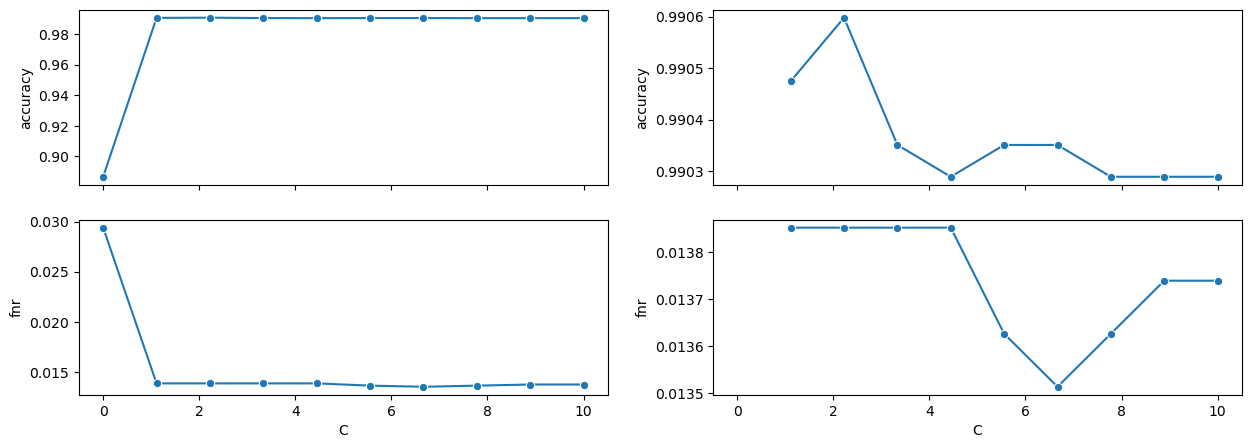

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
g_acc_1 = sns.lineplot(ax=axes[0,0], data=df_results, x='C', y='accuracy', marker="o", errorbar=None, legend=True)
g_acc_2 = sns.lineplot(ax=axes[0,1], data=df_results[df_results['C'] >= 0.001], x='C', y='accuracy', marker="o", errorbar=None, legend=True)
g_fnr_1 = sns.lineplot(ax=axes[1,0], data=df_results, x='C', y='fnr', marker="o", errorbar=None, legend=True)
g_fnr_2 = sns.lineplot(ax=axes[1,1], data=df_results[df_results['C'] >= 0.001], x='C', y='fnr', marker="o", errorbar=None, legend=True)
#sns.lineplot(data=df_results[df_results['C'] >= 0.001], x='C', y='fnr', marker="o", errorbar=None, legend=True)

Best results in terms of f1-score are obtained with:
- $C=6.66667$
- $FNR = \frac{FN}{FN+TP} = 0.0135$
- $Accuracy = 0.9903$

## RBF Kernel SVM

In [6]:
gamma_values = np.linspace(10e-6, 1, 10)
C_values = np.linspace(10e-6, 10, 10)

In [32]:
params_grid = {
    'gamma': gamma_values,
    'C': C_values
}
kfold_scores = model_evaluator.grid_search_kfold_cv(X=X_train, y=y_train, model=SVC(kernel='rbf'), params_grid=params_grid, k=5)
#99 minutes
kfold_scores

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000e-05, 1.11112e+00, 2.22223e+00, 3.33334e+00, 4.44445e+00,
       5.55556e+00, 6.66667e+00, 7.77778e+00, 8.88889e+00, 1.00000e+01]),
                         'gamma': array([1.0000e-05, 1.1112e-01, 2.2223e-01, 3.3334e-01, 4.4445e-01,
       5.5556e-01, 6.6667e-01, 7.7778e-01, 8.8889e-01, 1.0000e+00])},
             refit='fnr',
             scoring={'accuracy': make_scorer(<lambda>),
                      'fnr': make_scorer(<lambda>, greater_is_better=False)})

In [33]:
kfold_scores.best_params_

{'C': 1e-05, 'gamma': 1e-05}

In [41]:
y_pred = kfold_scores.best_estimator_.predict(X_train)

{'fn': 0, 'f1-score': 0.7090669541262425, 'accuracy': 0.5492670254221562}

In [43]:
# save the output of kfold_scores
df_results_minmax_accuracydf_results = pd.DataFrame({'C': [p['C'] for p in kfold_scores.cv_results_['params']],
                           'gamma': [p['gamma'] for p in kfold_scores.cv_results_['params']],
                           'accuracy': kfold_scores.cv_results_['mean_test_accuracy'],
                           'fnr': -kfold_scores.cv_results_['mean_test_fnr']})
df_results.to_csv('rbf_svm_results.csv', index=False)

In [7]:
df_results = pd.read_csv('rbf_svm_results.csv')

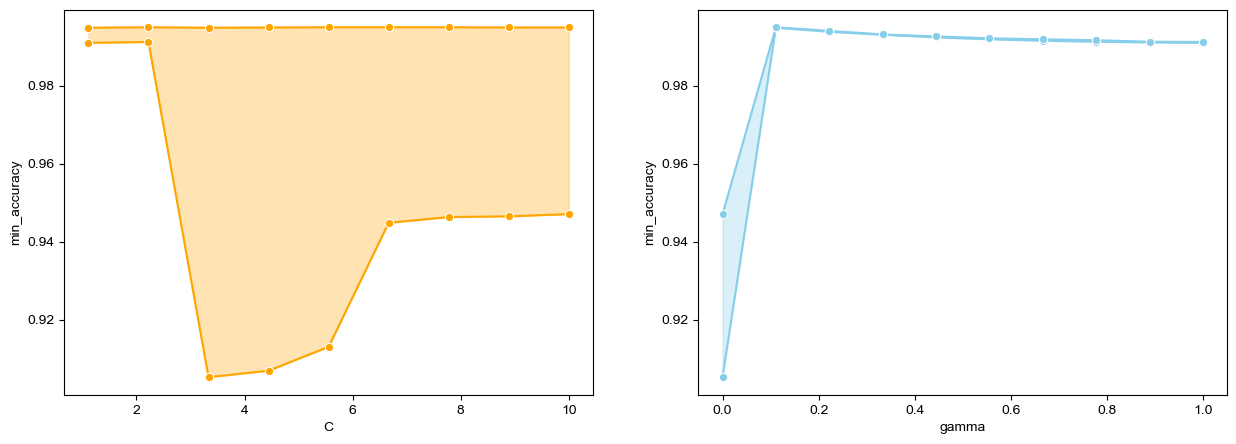

In [8]:
df_results_minmax_accuracy = df_results[df_results['accuracy']>0.9].groupby(by=['C']).agg(
    max_accuracy=('accuracy', np.max),
    min_accuracy=('accuracy', np.min)
).reset_index()
df_results_minmax_gamma = df_results[df_results['accuracy']>0.9].groupby(by=['gamma']).agg(
    max_accuracy=('accuracy', np.max),
    min_accuracy=('accuracy', np.min)
).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.set_theme(style="darkgrid")
sns.lineplot(ax=axes[0],data=df_results_minmax_accuracy, x='C', y='min_accuracy', marker="o", color='orange', errorbar=None, legend=True)
sns.lineplot(ax=axes[0],data=df_results_minmax_accuracy, x='C', y='max_accuracy', marker="o", color='orange', errorbar=None, legend=True)
g_acc_1 = axes[0].fill_between(
                       data=df_results_minmax_accuracy, 
                       x='C', 
                       y1='min_accuracy', 
                       y2='max_accuracy',
                       alpha=0.3,
                       color='orange')
sns.lineplot(ax=axes[1],data=df_results_minmax_gamma, x='gamma', y='min_accuracy', marker="o", color='skyblue', errorbar=None, legend=True)
sns.lineplot(ax=axes[1],data=df_results_minmax_gamma, x='gamma', y='max_accuracy', marker="o", color='skyblue', errorbar=None, legend=True)
g_acc_1 = axes[1].fill_between(
                       data=df_results_minmax_gamma, 
                       x='gamma', 
                       y1='min_accuracy', 
                       y2='max_accuracy',
                       alpha=0.3,
                       color='skyblue')

### Influence of the C hyperparameter

/var/folders/48/1_svc68j0_b2js686ls_zqhh0000gn/T/ipykernel_1081/3237169864.py:3: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.

/var/folders/48/1_svc68j0_b2js686ls_zqhh0000gn/T/ipykernel_1081/3237169864.py:4: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.



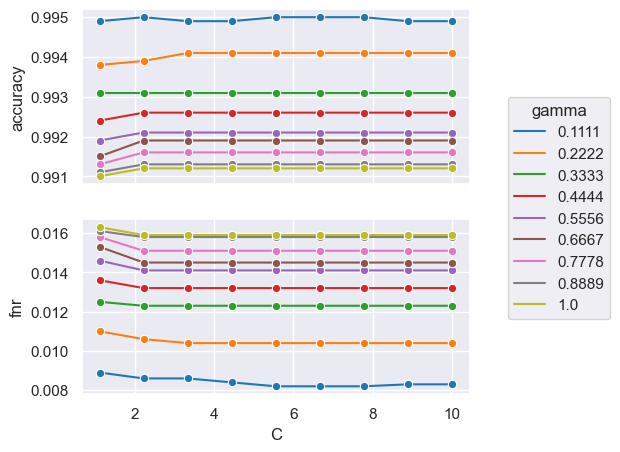

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
df_results = df_results.round(decimals=4)
g_acc_2 = sns.lineplot(ax=axes[0],data=df_results[(df_results['C'] > C_values[0]) & (df_results['gamma'] > gamma_values[0])], x='C', y='accuracy', hue='gamma', palette=sns.color_palette("tab10"), marker="o", errorbar=None, legend=True)
g_fnr_2 = sns.lineplot(ax=axes[1],data=df_results[(df_results['C'] > C_values[0]) & (df_results['gamma'] > gamma_values[0])], x='C', y='fnr', hue='gamma', palette=sns.color_palette("tab10"), marker="o", errorbar=None, legend=False)
g_acc_2.legend(bbox_to_anchor=(1.1, 0.5),
           borderaxespad=0,
           title='gamma')

### Influence of the gamma hyperparameter 

/var/folders/48/1_svc68j0_b2js686ls_zqhh0000gn/T/ipykernel_1081/1944758694.py:3: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.

/var/folders/48/1_svc68j0_b2js686ls_zqhh0000gn/T/ipykernel_1081/1944758694.py:4: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.



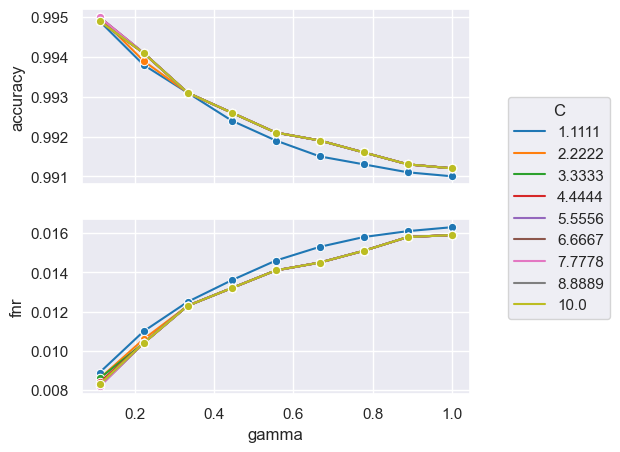

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
df_results = df_results.round(decimals=4)
g_acc_2 = sns.lineplot(ax=axes[0],data=df_results[(df_results['C'] > C_values[0]) & (df_results['gamma'] > gamma_values[0])], x='gamma', y='accuracy', hue='C', palette=sns.color_palette("tab10"), marker="o", errorbar=None, legend=True)
g_fnr_2 = sns.lineplot(ax=axes[1],data=df_results[(df_results['C'] > C_values[0]) & (df_results['gamma'] > gamma_values[0])], x='gamma', y='fnr', hue='C', palette=sns.color_palette("tab10"), marker="o", errorbar=None, legend=False)
g_acc_2.legend(bbox_to_anchor=(1.1, 0.5),
           borderaxespad=0,
           title='C')

What it can be noticed is that the influence of $\gamma$ is much stronger and more evident than the influence of the $C$ parameter. When the value of $\gamma$ is sufficiently small the accuracy reaches the top values and the same for the FNR that reaches the lowest possible values. What is not displayed in the plot is what happens with $C=10^{-5}$ and $\gamma=10^{-5}$, parameters under which the classifier performs a very poor analysis in terms of accuracy (around $54%$) but with $FPR=0$. This is not better than a dummy classifier so we don't take into account this values anymore.

We still optimize for the $FPR$ but without considering this corner case:

In [11]:
df_results_mod = df_results[df_results['accuracy'] > 0.9].reset_index()
best_params_accuracy = df_results_mod[df_results_mod['fnr'] == df_results_mod['fnr'].min()].reset_index()
best_C, best_gamma = best_params_accuracy.iloc[0,:].C, best_params_accuracy.iloc[0,:].gamma
print('Best parameters in terms of accuracy: C=%.4f, gamma=%.4f'%(best_C, best_gamma))
print('Performances: accuracy=%.4f, FNR=%.4f'%(best_params_accuracy.iloc[0,:].accuracy, best_params_accuracy.iloc[0,:].fnr))

Best parameters in terms of accuracy: C=5.5556, gamma=0.1111
Performances: accuracy=0.9950, FNR=0.0082


## Performance analysis on the test set

Now i am going to train the RBF SVM on the entire training set with the selected optimal parameters:

$C = 5.5556$, $\gamma = 0.1111$

And i make predictions for each sampel of `X_test`:

In [16]:
rbf_svm_test = SVC(kernel='rbf', C=best_C, gamma=best_gamma).fit(X_train,y_train)
rbf_metrics = model_evaluator.get_metrics(y_test, rbf_svm_test.predict(X_test))
print('## Performance on Test test for RBF SVM (C=5.5556, gamma=0.1111) ##')
print('FNR = %.2f%%\nAccuracy = %.2f%%'%(rbf_metrics['fnr']*100, rbf_metrics['accuracy']*100))

## Performance on Test test for RBF SVM (C=5.5556, gamma=0.1111) ##
FNR = 0.36%
Accuracy = 99.73%


Now i am going to train the linear SVM on the entire training set with the selected optimal parameters:

$C = 6.6667$

And i make predictions for each sampel of `X_test`:

In [15]:
lin_svm_test = SVC(kernel='linear', C=6.6667).fit(X_train,y_train)
lin_metrics = model_evaluator.get_metrics(y_test, lin_svm_test.predict(X_test))
print('## Performance on Test test for linear SVM (C=6.6667) ##')
print('FNR = %.2f%%\nAccuracy = %.2f%%'%(lin_metrics['fnr']*100, lin_metrics['accuracy']*100))
#11min

## Performance on Test test for linear SVM (C=6.6667) ##
FNR = 1.58%
Accuracy = 99.06%


## ROC/AUC plot of RBF SVM vs linear SVM

In [17]:
y_test_pred_scores_rbf = rbf_svm_test.decision_function(X_test)
y_test_pred_scores_lin = lin_svm_test.decision_function(X_test)
#10min

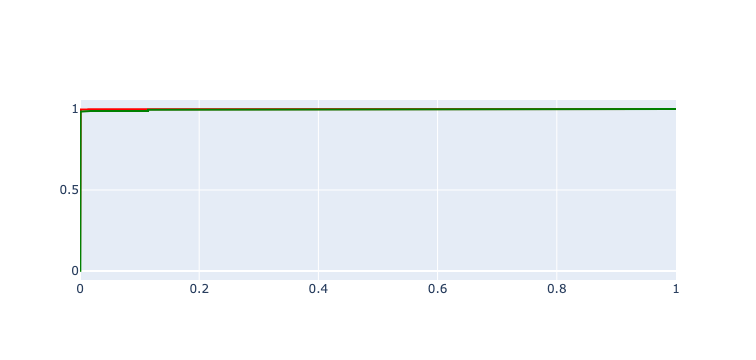

In [18]:
test_fpr_rbf, test_tpr_rbf, _ = roc_curve(y_test, y_test_pred_scores_rbf)
test_fpr_lin, test_tpr_lin, _ = roc_curve(y_test, y_test_pred_scores_lin)
roc_test_trace_rbf = px.line(x=test_fpr_rbf, y=test_tpr_rbf)
roc_test_trace_rbf.update_traces(line_color='red')
roc_test_trace_lin = px.line(x=test_fpr_lin, y=test_tpr_lin)
roc_test_trace_lin.update_traces(line_color='green')
fig = go.Figure(data=roc_test_trace_rbf.data + roc_test_trace_lin.data)
fig.show()

## Attack a kernel SVM

In [12]:
svm_rbf_clf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_rbf_clf.fit(X_train, y_train)

SVC(C=5.5556, gamma=0.1111)

In [57]:
# now i choose a random malign sample
x0 = df_tot[df_tot['malware'] == True].drop(["malware"], axis=1).iloc[0:1].values.astype(int)
# Perform the evasion
x_crafted, iter = iterative_sum_evasion(svm_rbf_clf, X_train, x0, y_train, best_gamma, 0.05, iprint=False, save_updates=False)
print('Evasion completed in %d iterations'%(iter))

ValueError: operands could not be broadcast together with shapes (1,21) (16167,) 

In [50]:
svm_rbf_clf.predict(np.ceil(x_crafted))

array([False])

In [56]:
avg_iter = 0
success = 0
for i in range(X_train.shape[0]):
    x0 = X_train[i:i+1,:]
    x_crafted, iter = iterative_sum_evasion(svm_rbf_clf, X_train, x0, y_train, 0.1, 0.05, iprint=False, save_updates=False)
    avg_iter += iter
    label = svm_rbf_clf.predict(np.ceil(x0))
    success += not(label)
    if i>=10:
        break
avg_iter /= 4#X_train.shape[0]
print('%f %d'%(avg_iter, success))

14.000000 8


### Visualizing the evasion attack

We start by obtaining a 2D version of the dataset using PCA with 2 components. Secondly, we apply a standard scaler preprocessing to improve the quality of the visualization. We train a RBF SVM with the selected parameters $C=1$ and $\gamma=0.01$

In [57]:
import random
# Apply PCA with 2 components for visualizing the samples
X_train_2D = PCA(n_components=2).fit(X_train).transform(X_train)
# Take only a subset of the samples to improve the quality of the plot
M = 200
mask = np.array(random.sample(range(0, X_train_2D.shape[0]-1), M))
X_train_2D = X_train_2D[mask,:]
y_train_2D = y_train[mask]
# Standardize the features values between 0 and 1
scaler = StandardScaler()
X_train_2D = scaler.fit(X_train_2D).transform(X_train_2D)
# Apply PCA 
svm_rbf_clf_2D = SVC(kernel='rbf', C=1, gamma=0.1)
svm_rbf_clf_2D.fit(X_train_2D, y_train_2D)
x0 = X_train_2D[y_train_2D == True][0:1]

/Users/mattiarosso/opt/anaconda3/envs/malis/lib/python3.8/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



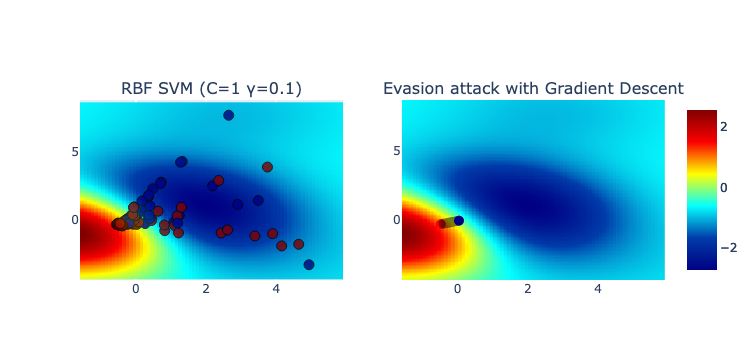

In [59]:
# Display the RBF SVM decision boundary
h=0.1
x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
x_ = np.arange(x_min, x_max, h)
y_ = np.arange(y_min, y_max, h)
xx, yy = np.meshgrid(x_, y_)
Z = svm_rbf_clf_2D.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = tools.make_subplots(rows=1, cols=2,
                          subplot_titles=("RBF SVM (C=1 γ=0.1)",
                                          "Evasion attack with Gradient Descent")
                         )
tr_points = go.Scatter(x=X_train_2D[:, 0], y=X_train_2D[:, 1],
                    mode='markers',
                    showlegend=False,
                    opacity=0.8,
                    marker=dict(size=10,
                                color=y_train.astype(int), 
                                colorscale='Jet',
                                line=dict(color='black', width=1))
                   )
tr_heatmap = go.Heatmap(x=x_, y=y_, z=Z, colorscale='Jet', showscale=True)
#fig = go.Figure(data=[trace2, trace1])   
fig.append_trace(tr_points, 1, 1)
fig.append_trace(tr_heatmap, 1, 1)
# Display the point that is targeted by the attack and the crafted  PDF
x_attacked, _, updates = iterative_sum_evasion(svm_rbf_clf_2D, 
                                                X_train_2D, 
                                                x0, 
                                                y_train_2D, 
                                                0.1, 
                                                0.05, 
                                                iprint=False, 
                                                save_updates=True)
tr_x0 = go.Scatter(x=[x0[0,0]], y=[x0[0,1]],
                    mode='markers',
                    showlegend=False,
                    opacity=1,
                    marker_size=10,
                    marker_color='red'
                   )
tr_attacked = go.Scatter(x=[x_attacked[0,0]], y=[x_attacked[0,1]],
                    mode='markers',
                    showlegend=False,
                    opacity=1,
                    marker_size=10,
                    marker_color='blue'
                   )
tr_updates = go.Scatter(x=updates[:,0], y=updates[:,1],
                    mode='markers',
                    showlegend=False,
                    opacity=0.5,
                    marker_size=10,
                    marker_color='black'
                   )
fig.append_trace(tr_x0, 1, 2)
fig.append_trace(tr_heatmap, 1, 2)
fig.append_trace(tr_attacked, 1, 2)
fig.append_trace(tr_updates, 1, 2)
fig.show()
#4min

- Compute theoretical success rate and practical success rate
- 

In [33]:
def iterative_sum_evasion(svm_rbf_clf, X_train, x0, y_train, gamma, step, iprint=True, save_updates=False):
    n = 0
    x_n = x0
    if iprint:
        print('Starting prediction value = %.3f'%(svm_rbf_clf.decision_function(x_n)))
        print('Step size = %.3f\n'%(gamma))
    updates=[]
    while True:
        # Compute f_phi(xn)
        # f_phi = svm_rbf_clf.decision_function(x_n) #f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma)
        # Compute grad_f_phi(xn)
        grad_f_phi_1 = grad_f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma)
        grad_f_phi_2 = grad_f_phi_xn_new(x_n,svm_rbf_clf,X_train,y_train,gamma)
        # Compute the perturbation
        # r_n = -f_phi/(np.linalg.norm(grad_f_phi)**2) * grad_f_phi
        # Perturbate the sample
        x_n = x_n - step * grad_f_phi_2
        if save_updates:
            updates.append(x_n)
        # Print logs
        if iprint:
            print('--- Evasion step: %d ---'%(n))
            print('Prediction value = %.3f'%(svm_rbf_clf.decision_function(x_n)))
            print('Prediction label = ', svm_rbf_clf.predict(x_n)[0])
            print('Gradient: ', grad_f_phi_2)
            #print('Norm^2 of gradient: %.3f'%(np.linalg.norm(grad_f_phi)**2))
            print('-------------------------')
        # Check if the sample has become benign
        if svm_rbf_clf.predict(x_n)[0] == False:
            break
        else:
            n += 1
    if iprint:
        print('Evasion completed in %d iterations'%(n+1))
    if save_updates:
        return x_n, n+1, np.concatenate(updates)
    else:
        return  x_n, n+1

In [18]:
def w_T_k(svm_rbf_clf,X_train,y_train,x_n,gamma):
    res = 0
    i = 0
    for sv in svm_rbf_clf.support_: 
        alpha = svm_rbf_clf.dual_coef_[0][i]
        y = 1 if y_train[i] is True else -1 
        x_i = X_train[sv:sv+1] 
        rbf = rbf_kernel(x_i,x_n,gamma=gamma)
        res += alpha * y * rbf
        i += 1
    return res

In [22]:
def f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma):
    f_phi_xn_w = w_T_k(svm_rbf_clf,X_train,y_train,x_n,gamma)
    f_phi_xn_b = svm_rbf_clf.intercept_
    return (f_phi_xn_w + (1/len(svm_rbf_clf.support_) * f_phi_xn_b)).ravel()

In [31]:
def grad_f_phi_xn(x_n,svm_rbf_clf,X_train,y_train,gamma):
    i = 0
    res = 0
    for sv in svm_rbf_clf.support_: 
        alpha = svm_rbf_clf.dual_coef_[0][i]
        y = 1 if y_train[i] is True else -1 
        x_i = X_train[sv:sv+1] 
        rbf = rbf_kernel(x_i,x_n,gamma=gamma)
        res += alpha * y * (x_i - x_n) * rbf
        i += 1
    return -2 * gamma * res

In [58]:
def grad_f_phi_xn_new(x_n,svm_rbf_clf,X_train,y_train,gamma):
    X_sub = X_train - x_n
    kernel = rbf_kernel(X_train,x_n.reshape(1,-1),gamma=gamma)
    grad = np.multiply(X_sub, kernel)
    alpha = np.zeros(shape=(X_train.shape[0]))
    alpha[svm_rbf_clf.support_] = svm_rbf_clf.dual_coef_
    y = np.where(y_train==True,1,-1)
    res = np.multiply(grad, (alpha * y).reshape(-1,1))
    res = -2 * gamma * np.sum(res, axis=0)
    return res

# Countermeasure against GD attack

In [ ]:
def adversarial_learning():
    features_list = np.ones(shape=(21))
    GD_features_used = np.ones(shape=(21))
    while 1:
        svm_clf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
        svm_clf.fit(X_train[:,features_list], y_train)
        
